In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.image_classification.controller.trainer_inception import InceptionTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.inceptionv3 import InceptionV3
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 299
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/inceptionv3")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [2]:
DEVICE = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [4]:
NUM_CLASS = 43

In [9]:
len(train_dataset)

26640

8


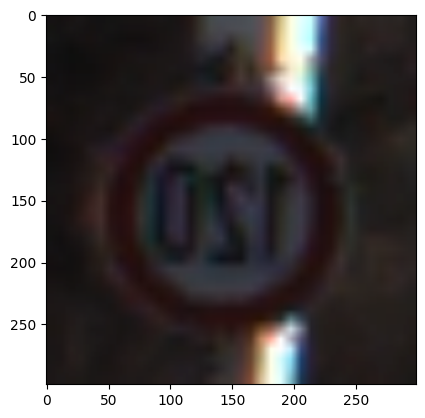

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [5]:
model = InceptionV3(output_size=NUM_CLASS, dropout_prob=0).to(DEVICE)

In [6]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
InceptionV3                                                       --
├─Sequential: 1-1                                                 --
│    └─Conv2dNormActivation: 2-1                                  --
│    │    └─Conv2d: 3-1                                           864
│    │    └─BatchNorm2d: 3-2                                      64
│    │    └─ReLU: 3-3                                             --
│    └─Conv2dNormActivation: 2-2                                  --
│    │    └─Conv2d: 3-4                                           9,216
│    │    └─BatchNorm2d: 3-5                                      64
│    │    └─ReLU: 3-6                                             --
│    └─Conv2dNormActivation: 2-3                                  --
│    │    └─Conv2d: 3-7                                           18,432
│    │    └─BatchNorm2d: 3-8                                      128
│    │    └─ReLU: 3-

# training

In [13]:
EPOCHS = 10
ACC_ITERS = 1

In [14]:
trainer = InceptionTrainer(EPOCHS, DEVICE, ACC_ITERS)
trainer.recorder.increment_data_size(len(train_dataset))

In [ ]:
criterion = trainer.get_criterion(NUM_CLASS, label_smoothing=1e-3)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

Enable AMP: False
Training...


100%|██████████| 832/832 [09:34<00:00,  1.45it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.1774e-01 (0.00%)


100%|██████████| 832/832 [04:31<00:00,  3.07it/s]


------------------------------------
Epoch 2
------------------------------------
total: 5.5884e-02 (-53.00%)


100%|██████████| 832/832 [04:23<00:00,  3.16it/s]


------------------------------------
Epoch 3
------------------------------------
total: 4.8712e-02 (-13.00%)


100%|██████████| 832/832 [04:20<00:00,  3.19it/s]


------------------------------------
Epoch 4
------------------------------------
total: 4.7071e-02 (-3.00%)


100%|██████████| 832/832 [04:20<00:00,  3.19it/s]


------------------------------------
Epoch 5
------------------------------------
total: 4.6655e-02 (-1.00%)


100%|██████████| 832/832 [04:21<00:00,  3.19it/s]


------------------------------------
Epoch 6
------------------------------------
total: 4.5953e-02 (-2.00%)


100%|██████████| 832/832 [04:21<00:00,  3.18it/s]


------------------------------------
Epoch 7
------------------------------------
total: 4.4870e-02 (-2.00%)


100%|██████████| 832/832 [04:19<00:00,  3.20it/s]


------------------------------------
Epoch 8
------------------------------------
total: 4.5292e-02 (1.00%)


100%|██████████| 832/832 [03:34<00:00,  3.88it/s]


------------------------------------
Epoch 9
------------------------------------
total: 4.4976e-02 (-1.00%)


100%|██████████| 832/832 [03:33<00:00,  3.90it/s]

------------------------------------
Epoch 10
------------------------------------
total: 4.4391e-02 (-1.00%)


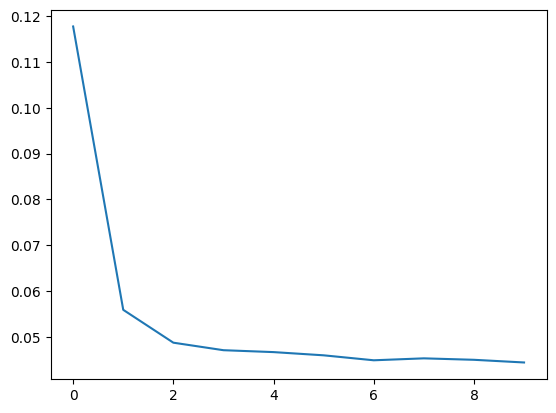

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 395/395 [03:01<00:00,  2.18it/s]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(NUM_CLASS), per_class_acc)

0         : 1.0
1         : 0.9972222222222222
2         : 1.0
3         : 0.9777777777777777
4         : 0.9893939393939394
5         : 0.9746031746031746
6         : 0.88
7         : 0.9955555555555555
8         : 0.9244444444444444
9         : 1.0
10        : 0.9878787878787879
11        : 1.0
12        : 0.9478260869565217
13        : 0.9972222222222222
14        : 1.0
15        : 0.9904761904761905
16        : 1.0
17        : 1.0
18        : 0.9794871794871794
19        : 0.0
20        : 1.0
21        : 0.6666666666666666
22        : 0.8166666666666667
23        : 0.9866666666666667
24        : 0.9888888888888889
25        : 0.9958333333333333
26        : 1.0
27        : 0.5166666666666667
28        : 1.0
29        : 1.0
30        : 0.9866666666666667
31        : 0.9851851851851852
32        : 1.0
33        : 0.8857142857142857
34        : 0.7833333333333333
35        : 0.9333333333333333
36        : 0.9583333333333334
37        : 0.7666666666666667
38        : 0.9376811594202898


In [24]:
per_class_acc.mean()

np.float64(0.9029760049148319)

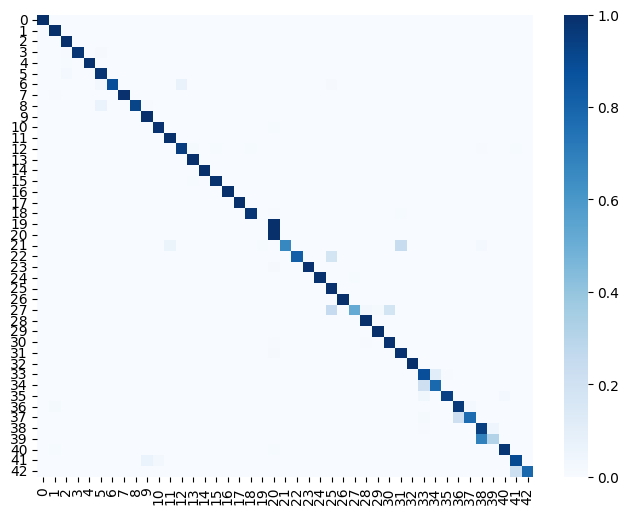

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(NUM_CLASS),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'inceptionv3.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'93.67MiB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>